# 数据挖掘互评作业四：离群点分析与异常检测--shuttle数据集分析

## 1. 问题描述
本次作业将从Anomaly Detection Meta-Analysis Benchmarks提供的benchmark数据集中任选两个进行分析。

## 2. 数据来源-shuttle
Anomaly Detection Meta-Analysis Benchmarks 借助使用Python Outlier Detection (PyOD)或其他已知的工具包来完成分析工作

In [1]:
import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

In [2]:
path = 'shuttle/benchmarks'
csv_list = os.listdir(path)
df = pd.read_csv(os.path.join(path,csv_list[0]))
df.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8
0,shuttle_point_51122,shuttle,multiclass,5,0.041548,nominal,4.883258,0.000249,2.656576,-0.007110,1.728989,0.015588,-2.752737,-0.694954,0.861543
1,shuttle_point_12551,shuttle,multiclass,4,0.187302,anomaly,0.552514,0.000249,0.747057,-0.007110,-1.872096,-0.034964,-0.083310,2.246491,1.954695
2,shuttle_point_07025,shuttle,multiclass,1,0.049188,nominal,0.634226,0.038732,1.084031,-0.007110,0.990305,0.029374,0.145498,-0.554885,-0.543937
3,shuttle_point_52737,shuttle,multiclass,3,0.868825,anomaly,-0.918305,-0.500020,-0.600838,-0.007110,-0.025386,-0.007391,0.450576,-0.228058,-0.465855
4,shuttle_point_04164,shuttle,multiclass,4,0.816420,anomaly,0.634226,0.000249,-0.937812,-0.089253,-1.041077,-0.007391,-1.151081,0.659044,1.095790


## 划分训练集和测试集
选取60%做为训练集40%做测试集，并把ground.truth中的'anomaly'设为1 'nominal'设为0

In [4]:
data_1 = pd.DataFrame()
for i in csv_list:
    df = pd.read_csv(os.path.join(path,i))
    data_1 = data_1.append(df[['V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'ground.truth']])

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_1, test_size=0.4, random_state=42)

def change_label(data, label_column='ground.truth'):
    x = data.drop(label_column, axis=1)#取V-V.9平均值
    y = []
    for i in data[label_column].values:
        if i == 'anomaly':
            y.append(1)
        else:
            y.append(0)
    y = np.array(y)
    return x, y

X_train, y_train = change_label(train)
X_test, y_test = change_label(test)

利用pyod中的包，用不同的模型进行离群点分析

## KNN

In [6]:
# train the KNN detector

clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.5792, precision @ rank n:0.2343

On Test Data:
KNN ROC:0.5801, precision @ rank n:0.241


## 可视化
利用TSNE对高维数据进行降维处理

In [9]:
from sklearn.manifold import TSNE
# T-SNE Implementation
X_train_tsne = TSNE(n_components=2, random_state=2000, init='pca', n_iter=2000).fit_transform(X_train.values)
X_test_tsne = TSNE(n_components=2, random_state=2000, init='pca', n_iter=2000).fit_transform(X_test.values)

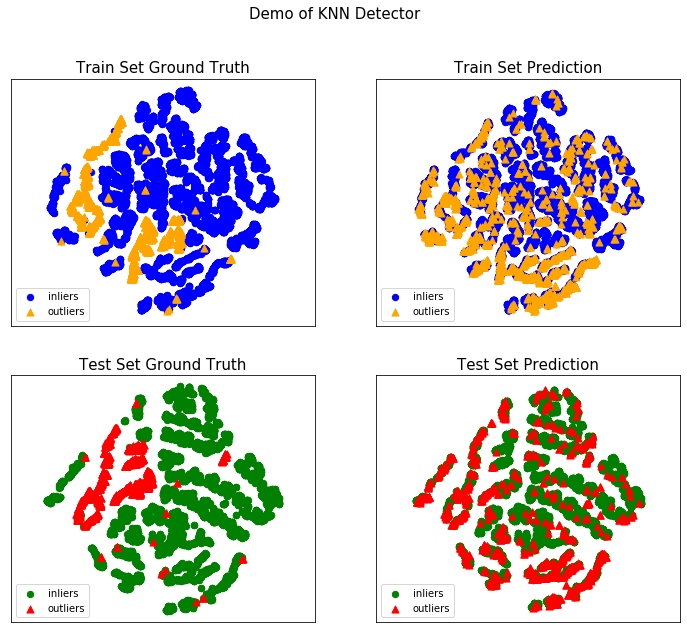

In [10]:
from pyod.utils.example import visualize
visualize(clf_name, X_train_tsne, y_train, X_test_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

## PCA

In [11]:
clf_name = 'PCA'
clf = PCA(n_components=3)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
PCA ROC:0.77, precision @ rank n:0.2278

On Test Data:
PCA ROC:0.7764, precision @ rank n:0.2436


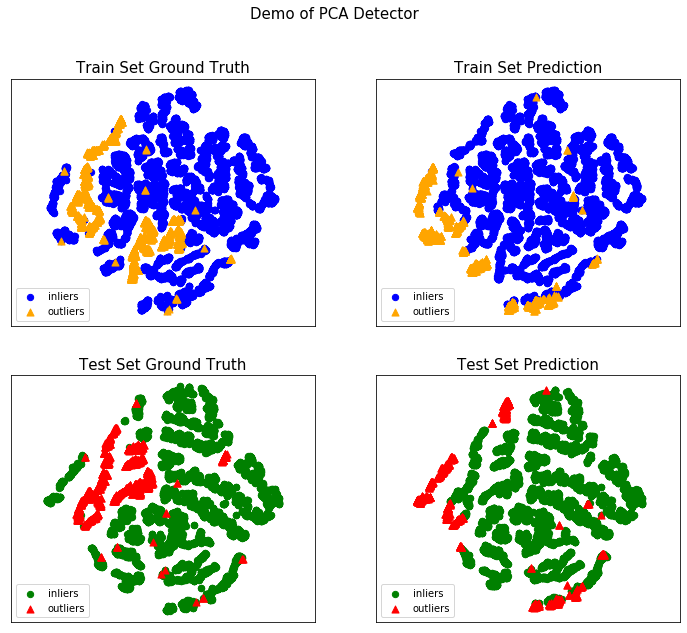

In [12]:
from pyod.utils.example import visualize
visualize(clf_name, X_train_tsne, y_train, X_test_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

## LOF

In [13]:
# train LOF detector
clf_name = 'LOF'
clf = LOF()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
LOF ROC:0.4823, precision @ rank n:0.1601

On Test Data:
LOF ROC:0.4817, precision @ rank n:0.1602


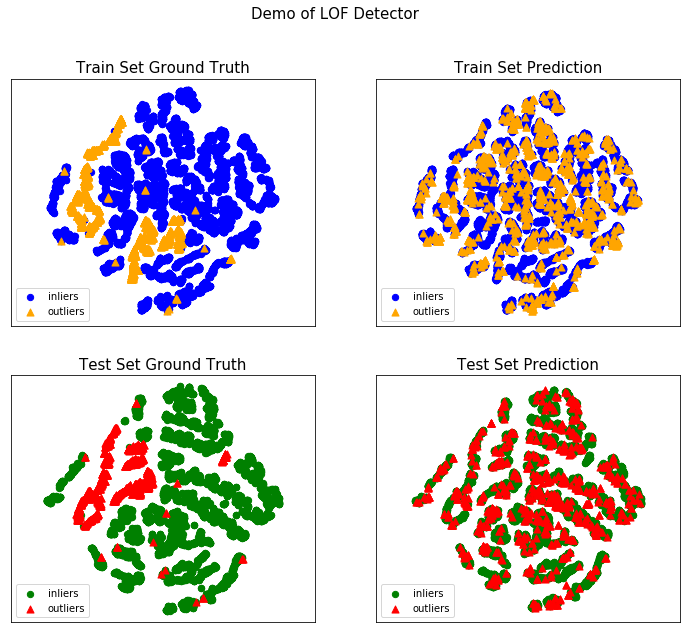

In [14]:
from pyod.utils.example import visualize
visualize(clf_name, X_train_tsne, y_train, X_test_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

对比KNN PCA LOF三种方法，在此数据集上PCA的效果更好，但还是不够好，可以再尝试别的模型方法